# Music genre Classification

Our project will include the following 5 parts. 
1. Visualize audio dataset: soundwave visualization, Fourier transform, Spectrogram, Mel Spectrogram, Harmonics and percussive, MFCC
2. EDA: Correlation among features & PCA 
4. Classification through feature data: Gtzan dataset have extracted import features as a new dataset, such as chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spectral_centroid_mean. We can use it as a feature dataset for classification. 
5. Classification through audio images: Beside classifying through features, we also process the image data from audio files and perform classification. In the end, we compare the performance between classifying through feature data and audio images. 





## 1. Visualize Audio Data

In [135]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd

In [136]:
import os
path = 'GTZAN/'
print(list(os.listdir(f'{path}/genres_original/')))

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']


In [137]:
# Importing 1 file
y_pop, sr_pop = librosa.load(f'{path}/genres_original/pop/pop.00036.wav')

print('y:', y_pop, '\n')
print('y shape:', np.shape(y_pop), '\n')
print('Sample Rate (KHz):', sr_pop, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661504/22050)

y: [-0.19229126 -0.08969116  0.02322388 ... -0.16653442 -0.0585022
  0.01345825] 

y shape: (661504,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.00018140589569


The sample rate of 22050 Hz was commonly used in early digital audio formats, such as the Audio Compact Disc (CD), which was introduced in the 1980s. CD audio is sampled at a rate of 44.1 kHz, which is twice the sample rate of 22050 Hz.

The reason why 44.1 kHz was chosen as the standard for CD audio is because it is capable of accurately representing audio frequencies up to 20 kHz, which is the upper limit of human hearing.

### 2D Representation: Sound Waves

Note on waveshow: x-axis represents time and the y-axis represents the amplitude of the audio signal.

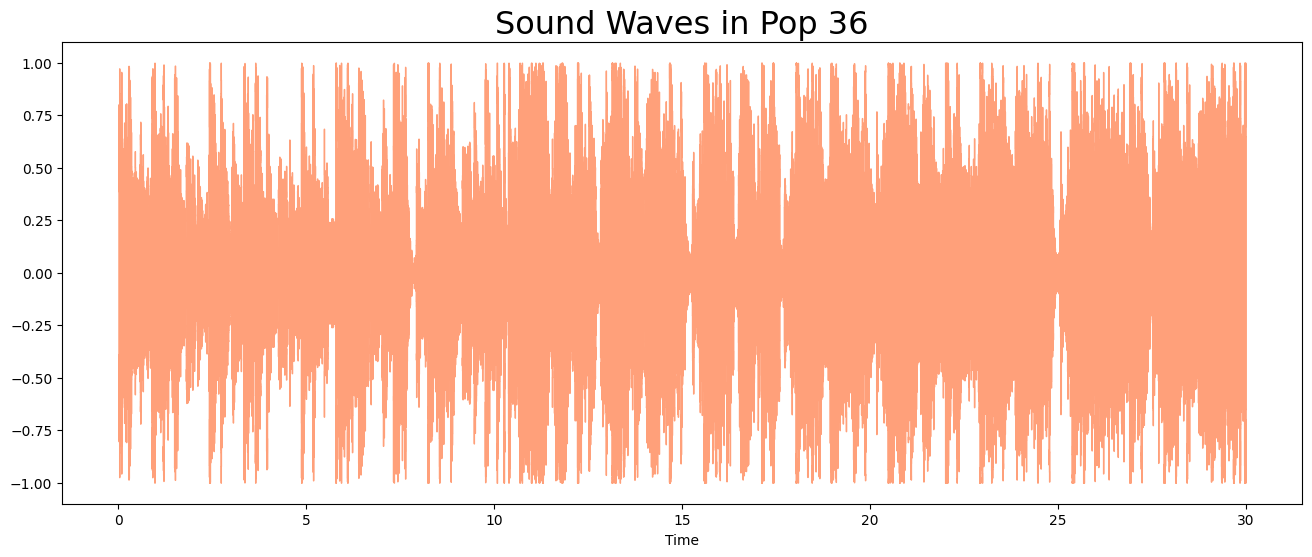

In [138]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=y_pop, sr=sr_pop, color='#FFA07A')
plt.title("Sound Waves in Pop 36", fontsize = 23);

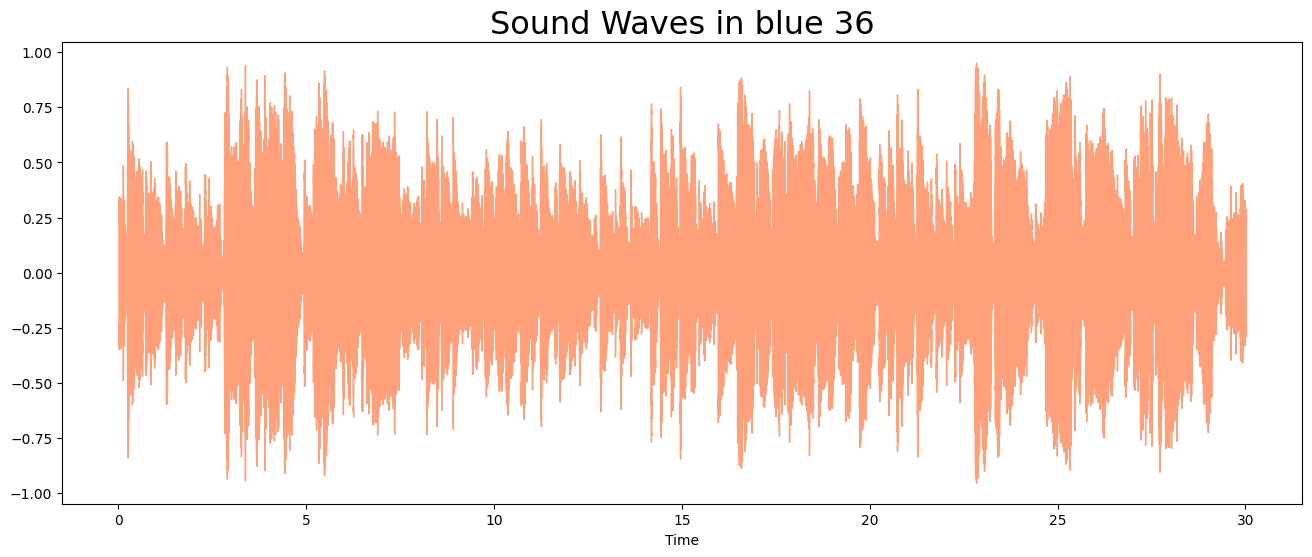

In [139]:
y_blue, sr_blue = librosa.load(f'{path}/genres_original/blues/blues.00036.wav')

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=y_blue, sr=sr_blue, color='#FFA07A')
plt.title("Sound Waves in blue 36", fontsize = 23);

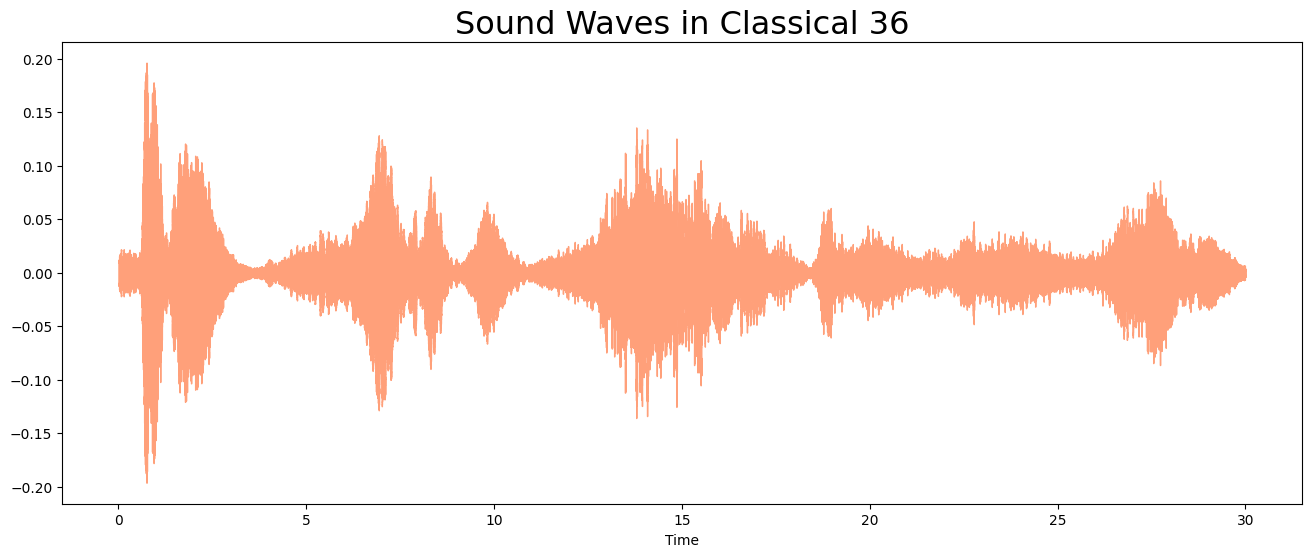

In [140]:
y_classical, sr_classical = librosa.load(f'{path}/genres_original/classical/classical.00036.wav')

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=y_classical, sr=sr_classical, color='#FFA07A')
plt.title("Sound Waves in Classical 36", fontsize = 23);

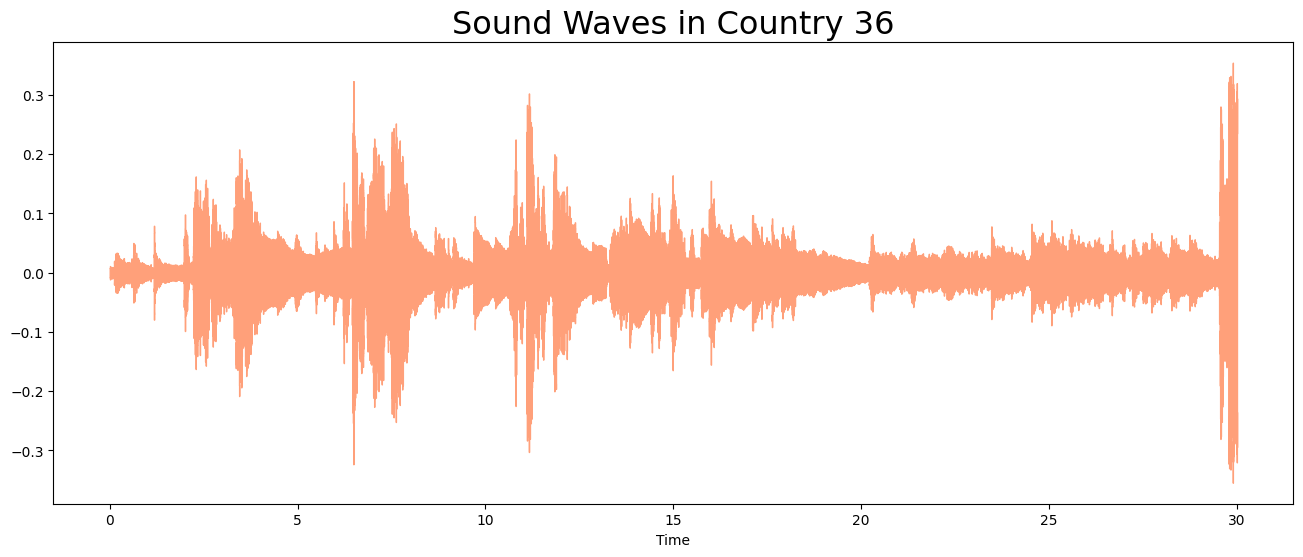

In [141]:
y_country, sr_country = librosa.load(f'{path}/genres_original/country/country.00036.wav')

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=y_country, sr=sr_country, color='#FFA07A')
plt.title("Sound Waves in Country 36", fontsize = 23);

### Fourier Transform

Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.

In [142]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(y_pop, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


The purpose of STFT is to add the time dimension back by breaking down signals into windows. (Window length: the time length of the window, hope length: the extent of window overlapping. The longer the hop length, the higher the freq resolutions (larger segments of the audio signals), but the lower the time resolution (few frames per unit of time) We then perform a Fourier transformation of the window to understand the pattern of the sounds.

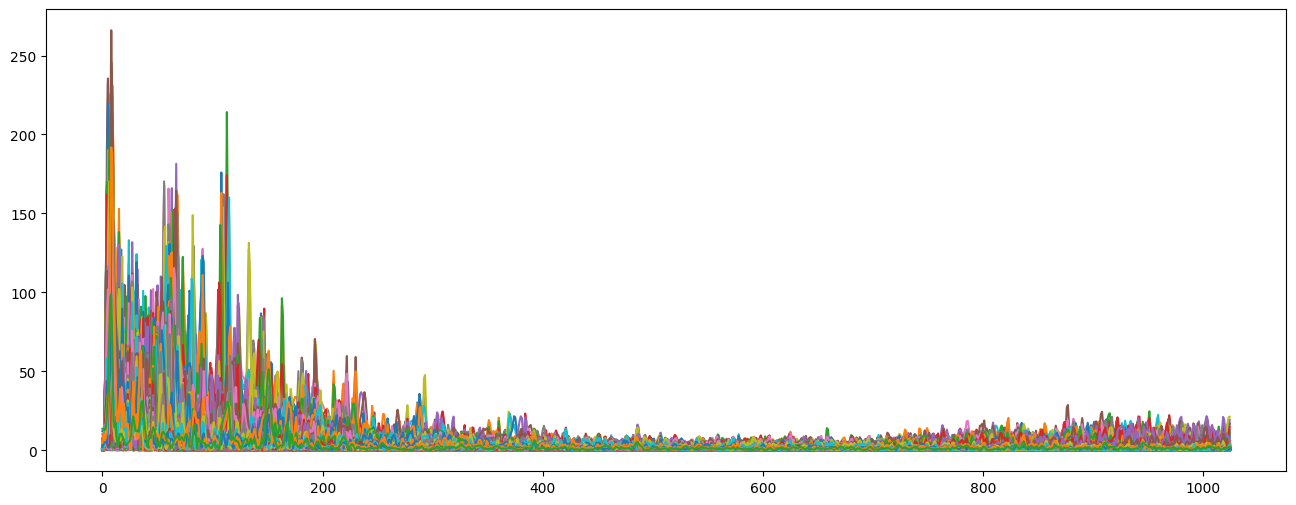

In [143]:
plt.figure(figsize = (16, 6))
plt.plot(D);

The resulting plot will show the frequency content of the audio signal over time. The x-axis of the plot represents time, with each point on the axis corresponding to a different time frame. The y-axis represents the frequency content of the signal, with each point on the axis corresponding to a different frequency band.

### Spectrogram

The horizontal axis of a spectrogram represents time, while the vertical axis represents frequency. The intensity of the spectrogram is represented by color or grayscale, with brighter colors indicating higher intensity or amplitude at a given frequency.

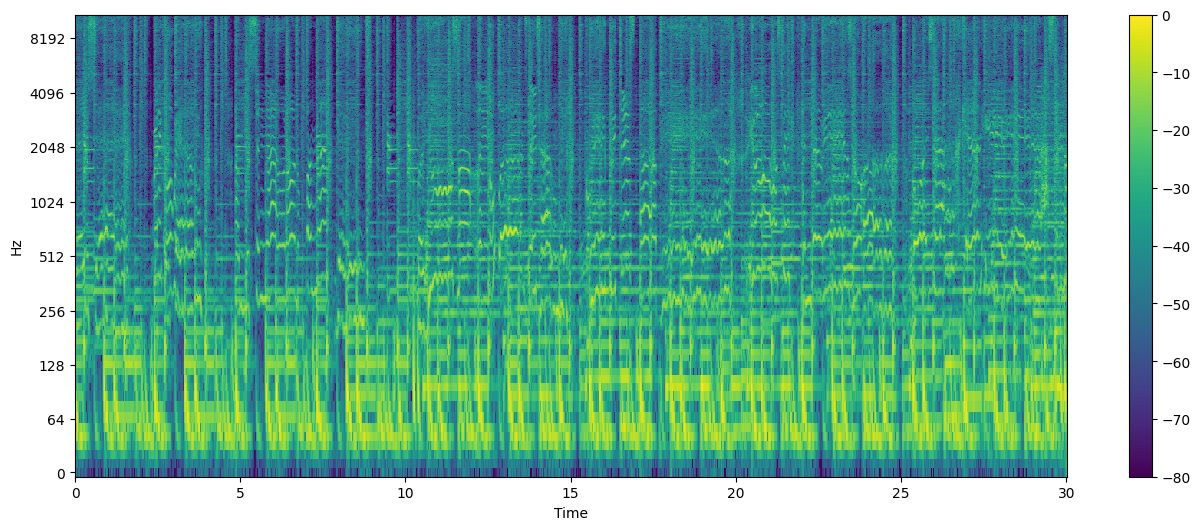

In [144]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr_pop, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'viridis')
plt.colorbar();

### Mel Spectrogram

Mel Scale - frequency for humans (Reason: human perceive the sound distance unlinearly)


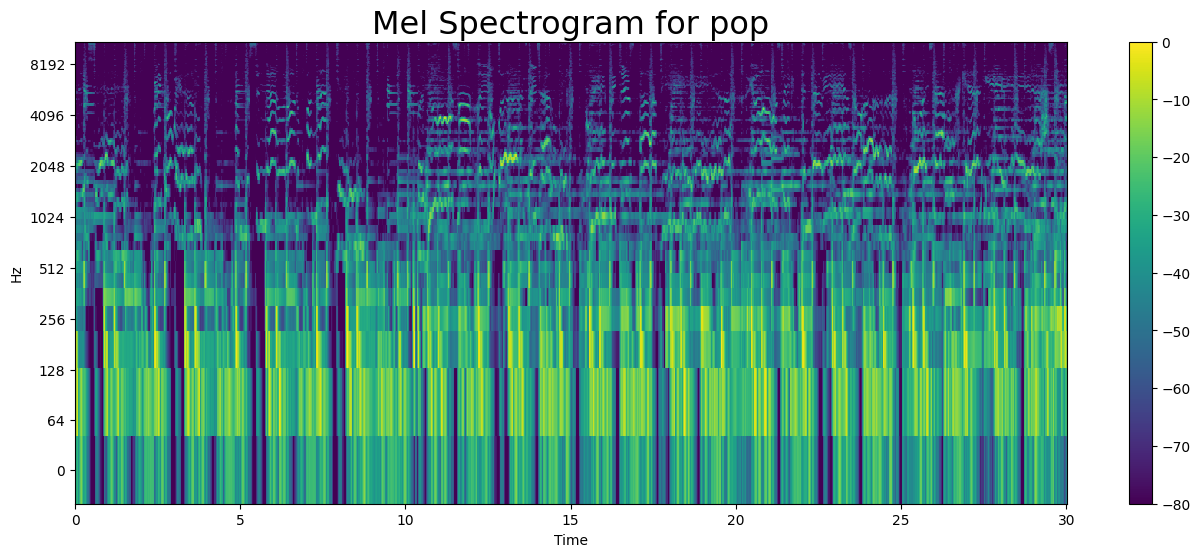

In [145]:

S = librosa.feature.melspectrogram(y = y_pop, sr=sr_pop)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr_pop, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'viridis');
plt.colorbar();
plt.title("Mel Spectrogram for pop", fontsize = 23);


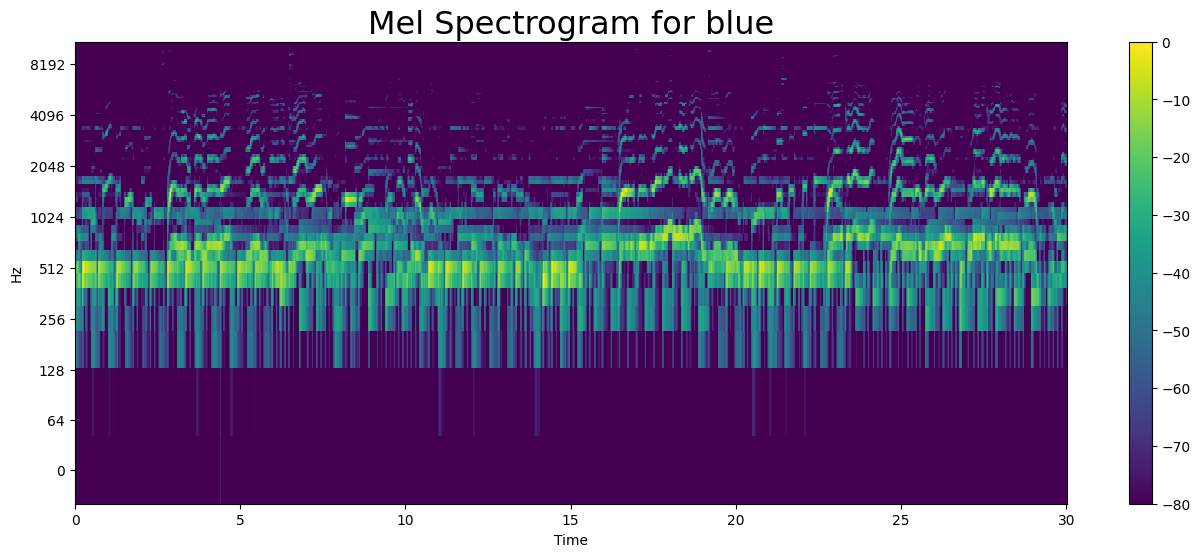

In [146]:
S = librosa.feature.melspectrogram(y = y_blue, sr=sr_blue)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr_blue, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'viridis');
plt.colorbar();
plt.title("Mel Spectrogram for blue", fontsize = 23);

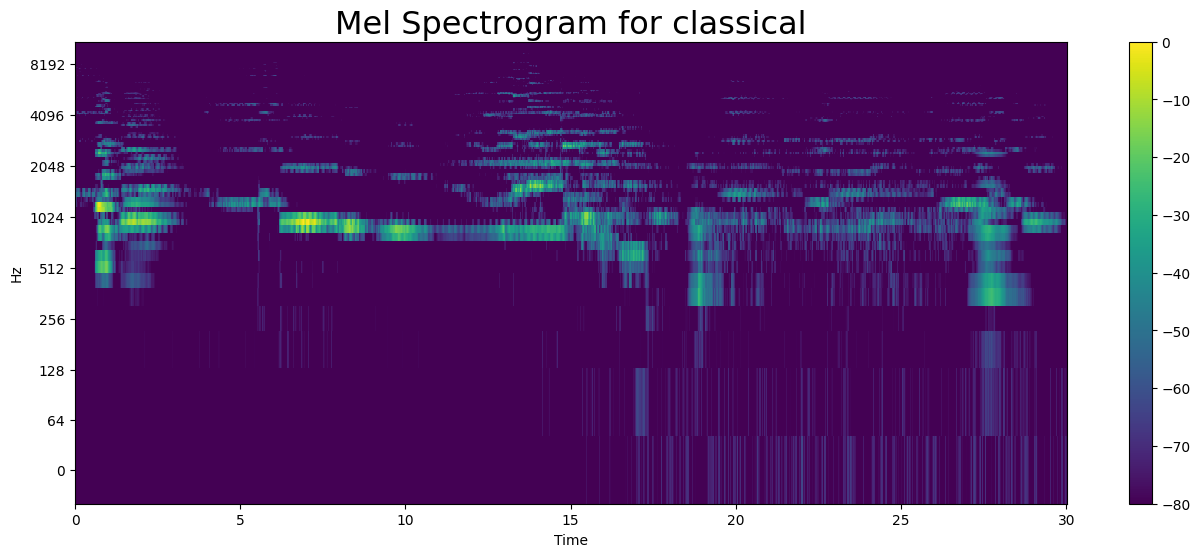

In [147]:

S = librosa.feature.melspectrogram(y = y_classical, sr=sr_classical)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr_classical, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'viridis');
plt.colorbar();
plt.title("Mel Spectrogram for classical", fontsize = 23);


Observations: Pop music have higher amplitudes. Blue music have smaller range of freuqency. Classical music seems to have the most dynamic frequency. 

### Audio Features

Zero Crossing Rate: Zero Crossing Rate (ZCR) is a measure of the number of times a signal crosses the zero-axis (amplitude) in a given time frame.



In [148]:
# Total zero_crossings for pop
zero_crossings = librosa.zero_crossings(y_pop, pad=False)
print(sum(zero_crossings))

# Total zero_crossings for blue
zero_crossings = librosa.zero_crossings(y_blue, pad=False)
print(sum(zero_crossings))

# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(y_classical, pad=False)
print(sum(zero_crossings))

76229
24463
39405


### Harmonics and percussive
- Harmonics: These are pitch sounds that enable us to hear melodies.
- Percussive sound: This is more like something originating from an instrument onset, like a beat on a drum.

The x-axis represents time and the y-axis represents the amplitude of the signal.


Text(0.5, 1.0, 'Harmonics and percussive for pop')

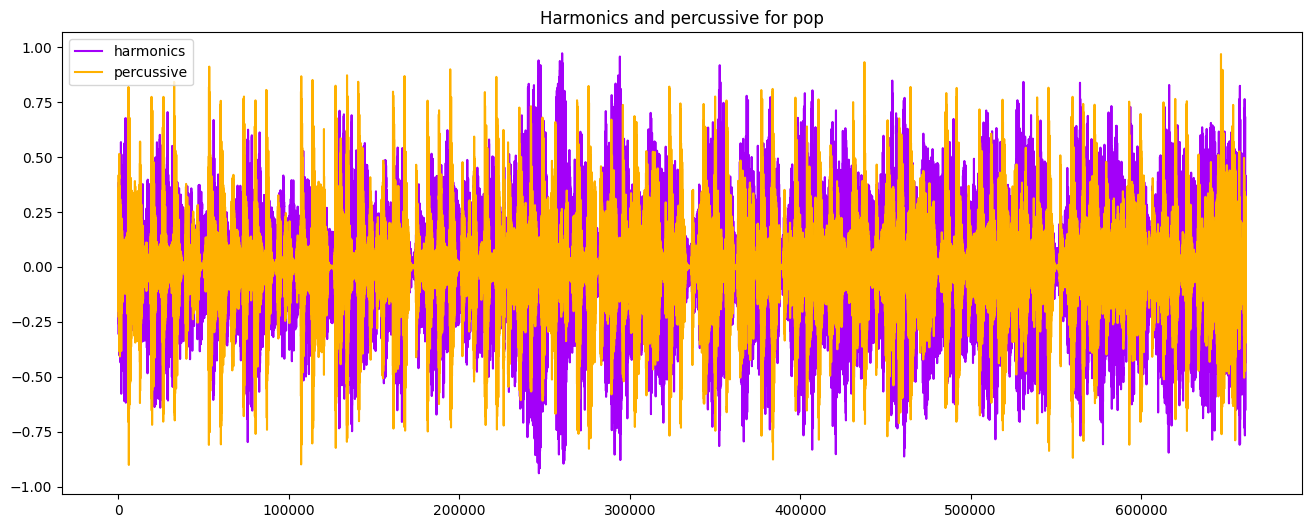

In [149]:
y_harm, y_perc = librosa.effects.hpss(y_pop)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9', label = 'harmonics');
plt.plot(y_perc, color = '#FFB100', label = 'percussive');
plt.legend()
plt.title('Harmonics and percussive for pop')

Text(0.5, 1.0, 'Harmonics and percussive for blue')

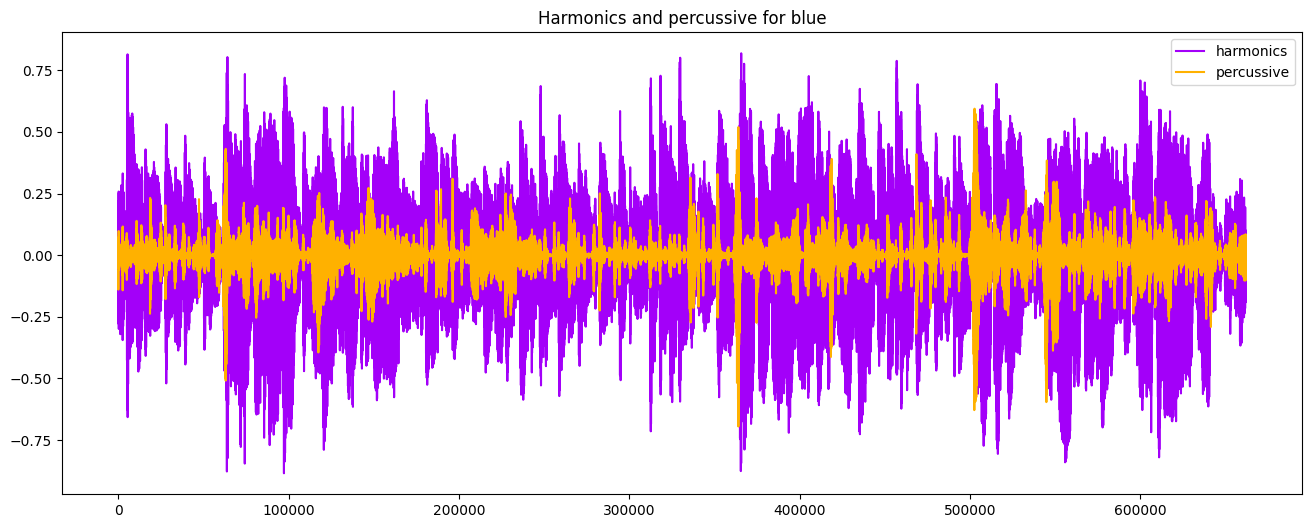

In [150]:
y_harm, y_perc = librosa.effects.hpss(y_blue)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9', label = 'harmonics');
plt.plot(y_perc, color = '#FFB100', label = 'percussive');
plt.legend()
plt.title('Harmonics and percussive for blue')

Text(0.5, 1.0, 'Harmonics and percussive for classical')

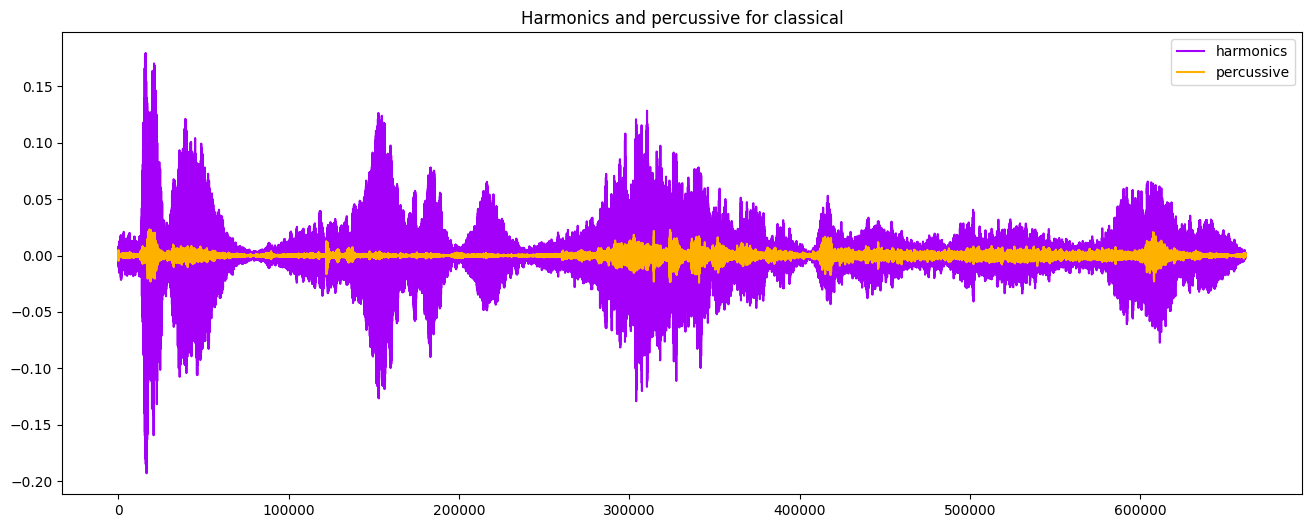

In [151]:
y_harm, y_perc = librosa.effects.hpss(y_classical)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9', label = 'harmonics');
plt.plot(y_perc, color = '#FFB100', label = 'percussive');
plt.legend()
plt.title('Harmonics and percussive for classical')

### Tempo BMP (beats per minute)

In [152]:
tempo, _ = librosa.beat.beat_track(y = y_pop, sr = sr_pop)
tempo

99.38401442307692

### MFCC
A compressed representation of the Mel Spectrograms by the most essential frequency coef. 

The x-axis of the MFCCs plot represents time, and the y-axis represents the MFCC coefficient values.

mfccs shape: (20, 1293)


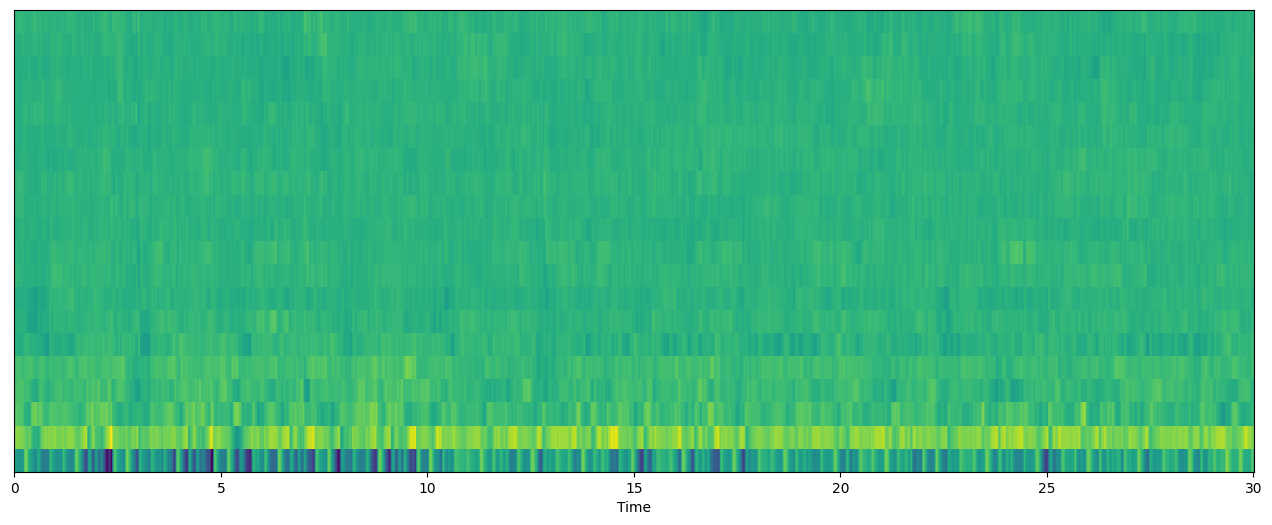

In [153]:
mfccs = librosa.feature.mfcc(y = y_pop, sr=sr_pop)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr_pop, x_axis='time', cmap = 'viridis');

Mean: -2.360215e-09 

Var: 1.0


/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


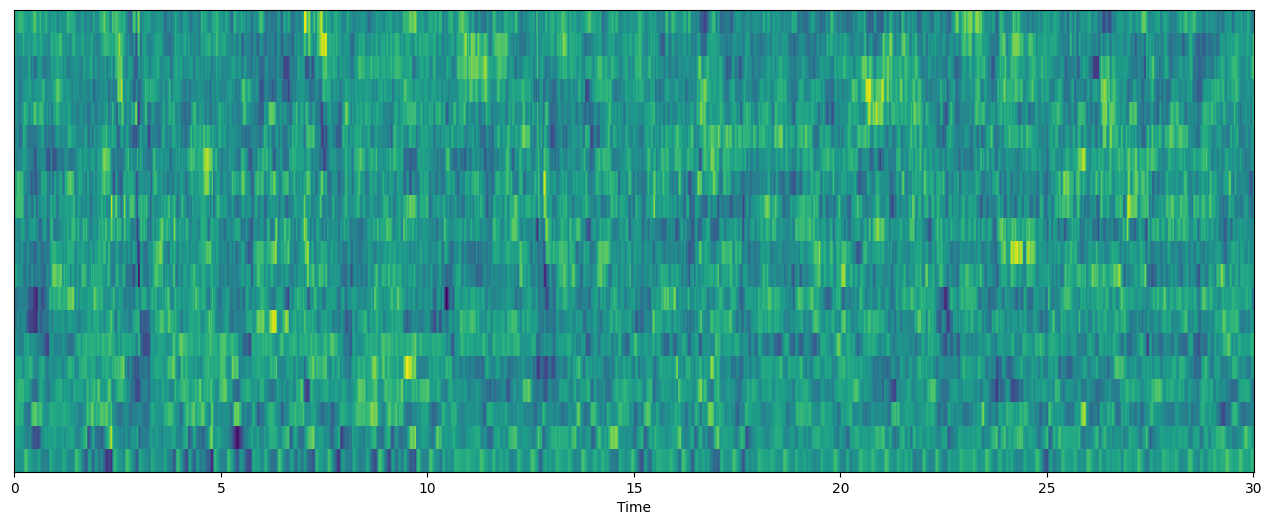

In [154]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr_pop, x_axis='time', cmap = 'viridis');

In [155]:
print(mfccs)

[[ 0.09206966  0.38610902  0.11332224 ...  1.2038206   1.370697
   0.82737654]
 [ 0.26141602  0.34526667  0.451189   ...  0.31910515  0.11388601
   0.18868302]
 [ 0.982792    0.8726585   1.0931873  ... -0.43070954 -0.5778949
  -0.76126564]
 ...
 [-0.32814997 -0.04034512 -0.27681282 ...  0.5647969   1.3951571
   2.1499693 ]
 [ 0.73992103  0.7570349  -0.0860804  ... -0.20964907  0.44987693
   1.7667273 ]
 [ 0.89229167  0.74019504  0.55440974 ... -0.8115252  -1.0920751
  -0.89953953]]


## 2. EDA

The dataset contains a list of features from the audio files such as spectral centroid (the weighted mean of the frequencies in an audio file). We use this dataset on machine learning methods to predict classification accuracy later on. 

In [156]:
data = pd.read_csv(f'{path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Corrrelation heap map

/var/folders/0h/xyv81g2n7sj6zr0c9cw30gkc0000gn/T/ipykernel_81575/4060137719.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


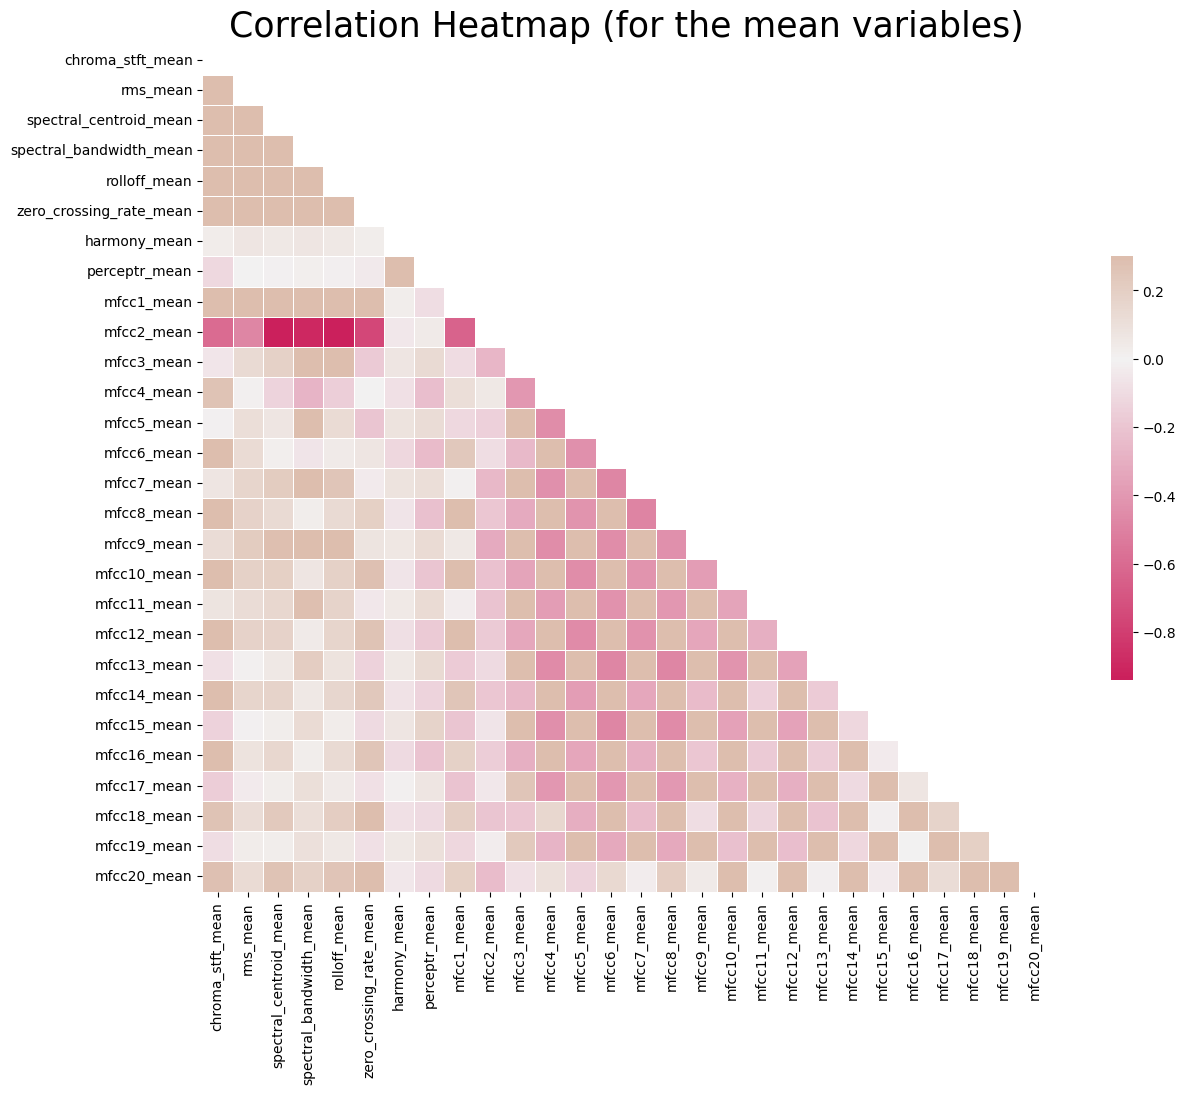

In [157]:
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the mean variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

It seems that chroma sfft mean, rms mean, spectral centriod mean, spectral bandwidth mean, rolloff mean zero cross rating mean seems to be the most meaningul variables with the strongest correlation relates to each other. 

### PCA

Since there are lots of similarities among features, we use PCA to condese the features and examine the possiblities for classification through componennts. 

In [158]:
from sklearn import preprocessing


data = data.drop(['filename'], axis=1)
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


Text(0.5, 1.0, 'PCA cumulative explained variance')

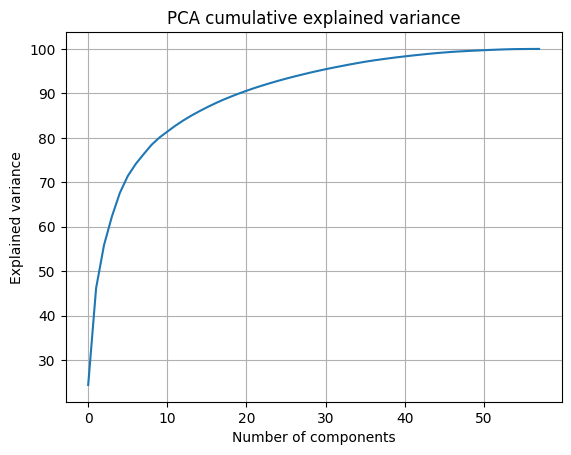

In [159]:
import numpy as np
from sklearn.decomposition import PCA
# Use 100 components to see explained variance 

pca_58 = PCA(n_components = 58)
pca_58.fit(X)

plt.grid()
plt.plot(np.cumsum(pca_58.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('PCA cumulative explained variance')

In [160]:
import pandas as pd
explained_var = np.cumsum(pca_58.explained_variance_ratio_ * 100).reshape(-1, 1)
num_comps = [i+1 for i in range(58)]
explained_var
explained_var_df = pd.DataFrame(explained_var,index=num_comps, columns = ['Explained Variance Ratio'])
explained_var_df

,Explained Variance Ratio
1,24.393550
2,46.175354
3,55.869008
4,62.307090
5,67.594676
6,71.390181
7,74.093713
8,76.294254
9,78.407186
10,80.051094


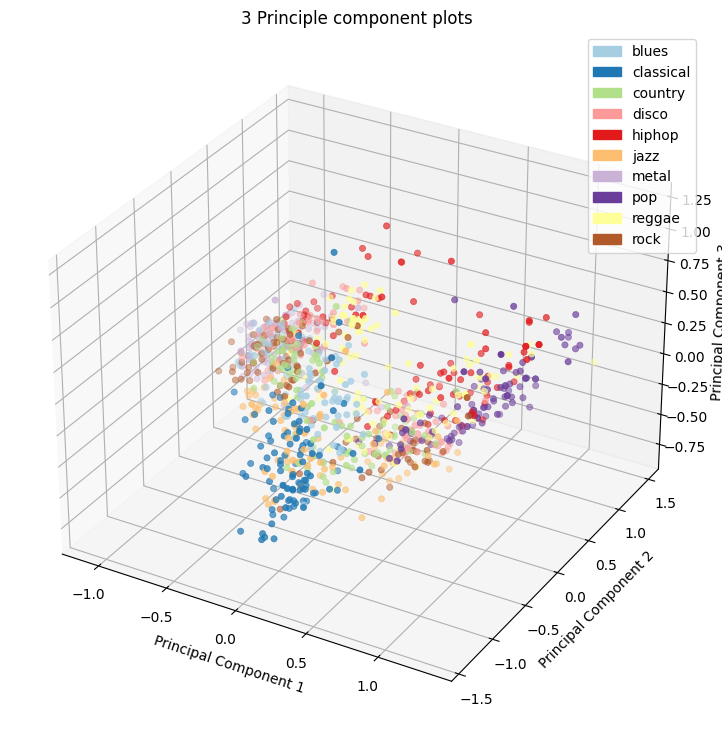

In [163]:
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder


pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

# Define an array of color names
le = LabelEncoder()
color_numbers = le.fit_transform(finalDf["label"])

fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(finalDf["principal component 1"], finalDf["principal component 2"], finalDf["principal component 3"],c = color_numbers, cmap='Paired', linewidth=0.5)

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3 Principle component plots')

# Find the label names and corresponding color codes
label_names = le.classes_
color_codes = plt.get_cmap('Paired')(np.linspace(0, 1, len(label_names)))

# Create a legend
legend_handles = [plt.Rectangle((0,0),1,1, color=color_codes[i], label=label_names[i]) for i in range(len(label_names))]
ax.legend(handles=legend_handles)

plt.show()



We can see that there are some patterns but it's not clearly visible to classify different types of music using thre components.

## 3. Classification through feature data
### 1D CNN classification

We cannot use 2D CNN classifier because of the small amount of features that are extracted from the audio dataset.

In [164]:
import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

In [165]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####
# Normalize so everything is on the same scale. 
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [167]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [170]:
X_train = np.asarray(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.asarray(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model and train it on the input data
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


2023-04-16 20:38:46.031905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 2.2839 - accuracy: 0.1200

2023-04-16 20:38:47.090227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 48ms/step - loss: 2.2839 - accuracy: 0.1200 - val_loss: 2.2835 - val_accuracy: 0.1700
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 2.2424 - accuracy: 0.3100 - val_loss: 2.2442 - val_accuracy: 0.2667
Epoch 3/20
22/22 [==============================] - 0s 10ms/step - loss: 2.1792 - accuracy: 0.2700 - val_loss: 2.1701 - val_accuracy: 0.2667
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 2.0734 - accuracy: 0.3414 - val_loss: 2.0739 - val_accuracy: 0.3000
Epoch 5/20
22/22 [==============================] - 0s 8ms/step - loss: 1.9246 - accuracy: 0.3886 - val_loss: 1.9275 - val_accuracy: 0.3500
Epoch 6/20
22/22 [==============================] - 0s 11ms/step - loss: 1.7557 - accuracy: 0.4286 - val_loss: 1.8002 - val_accuracy: 0.3900
Epoch 7/20
22/22 [==============================] - 0s 8ms/step - loss: 1.6009 - accuracy: 0.4786 - val_loss: 1.6542 - val_accuracy: 0.4833
Epoch 8/20
22/22 [========

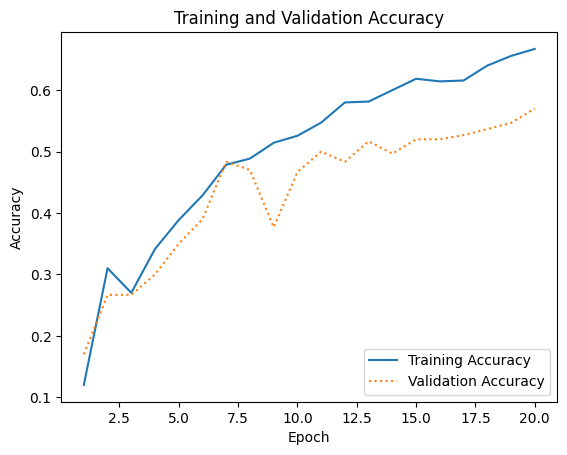

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Logistic Regression

In [172]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.46      0.46      0.46        35
           1       0.87      1.00      0.93        20
           2       0.70      0.51      0.59        37
           3       0.65      0.44      0.53        34
           4       0.63      0.71      0.67        24
           5       0.87      0.79      0.83        33
           6       0.53      0.90      0.67        30
           7       0.66      0.83      0.73        23
           8       0.50      0.52      0.51        29
           9       0.48      0.34      0.40        35

    accuracy                           0.62       300
   macro avg       0.63      0.65      0.63       300
weighted avg       0.63      0.62      0.61       300



/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### MLP classifier

In [173]:
from sklearn.neural_network import MLPClassifier

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.64      0.66      0.65        35
           1       0.86      0.90      0.88        20
           2       0.43      0.24      0.31        37
           3       0.36      0.38      0.37        34
           4       0.54      0.79      0.64        24
           5       0.81      0.67      0.73        33
           6       0.73      0.80      0.76        30
           7       0.85      0.74      0.79        23
           8       0.48      0.48      0.48        29
           9       0.40      0.49      0.44        35

    accuracy                           0.59       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.59      0.59      0.58       300



/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### XGboost classifer

In [176]:
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        35
           1       0.87      1.00      0.93        20
           2       0.79      0.70      0.74        37
           3       0.76      0.56      0.64        34
           4       0.59      0.83      0.69        24
           5       0.93      0.82      0.87        33
           6       0.69      0.90      0.78        30
           7       0.72      0.91      0.81        23
           8       0.68      0.59      0.63        29
           9       0.59      0.54      0.57        35

    accuracy                           0.74       300
   macro avg       0.74      0.76      0.74       300
weighted avg       0.74      0.74      0.73       300



Comparing the accuracy: 
- XGBoost: 0.74
- Logistic: 0.62
- MLP: 0.59
- 1D CNN: 0.5

We found that XGBoost has the best performance using the feature extracted dataset. 

## 4. Classification through audio images

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import os
from glob import glob
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
# from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt

In [4]:

input_dir = 'GTZAN/images_original/'

# Define input directory
def process_images(path): 
    images = []
    flattened = []
    # Loop over all images in input directory
    for filename in os.listdir(path):
        # Load image
        image_path = os.path.join(path, filename)
        image = cv2.imread(image_path)
        # print(image.shape)
        resize = cv2.resize(image, (100, 70))
        images.append(resize)
        flattened.append(np.array(resize).flatten())   
    X = np.asarray(flattened)        
    return images, flattened, X


def process_categories(input_dir):
    X_categories = []
    y_labels = []
    

    for i,subdir in enumerate(os.listdir(input_dir)):
        images, flattened, X = process_images(os.path.join(input_dir, subdir))
        X_categories.append(X)
        y_labels.append(np.full(len(X), i))
    X = np.vstack(X_categories)
    y = np.concatenate(y_labels)
    return X, y
    

X, y = process_categories(input_dir)


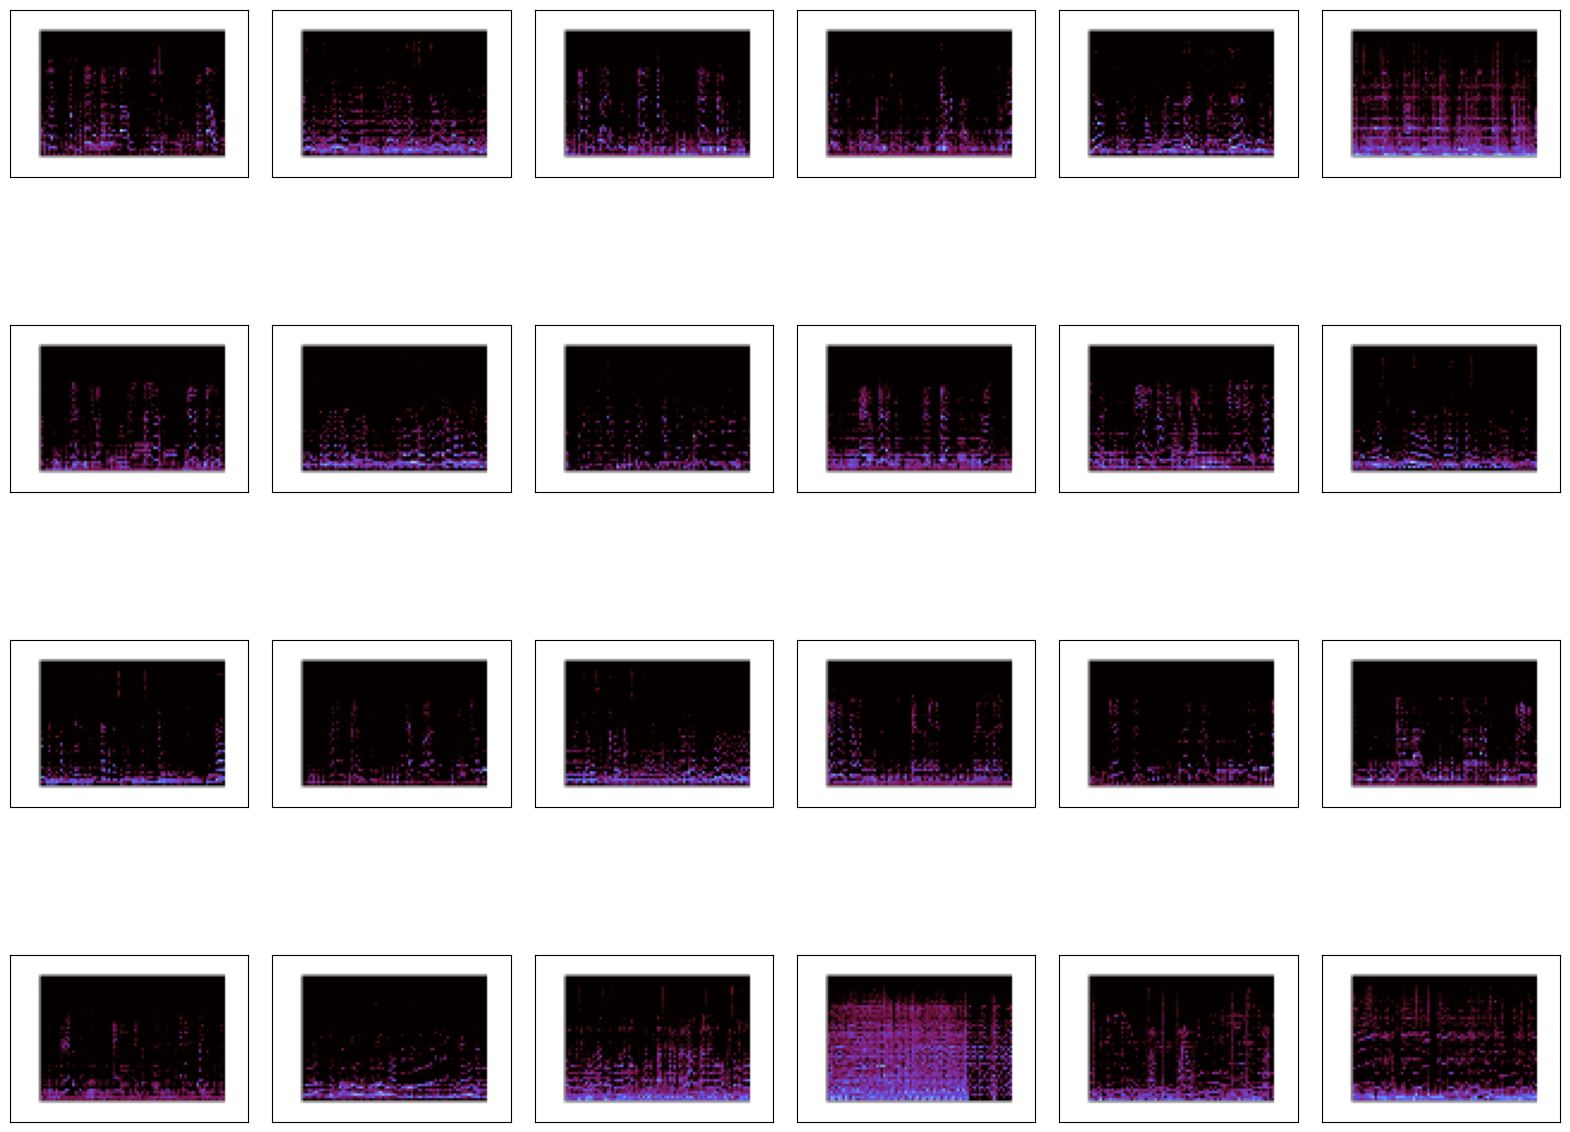

In [5]:
blue_dir = 'GTZAN/images_original/blues'
images_blue, flattened_blue , X_blue = process_images(blue_dir)

#plot the photos 
def original_photos(images):
    fig, ax = plt.subplots(4, 6, figsize=(20, 16),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

    k = 0
    for i in range(4):
        for j in range(6):
            ax[i, j].imshow(images[k])
            k += 1
            
    plt.show()
original_photos(images_blue)        

In [6]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=123)
print(f'There are {len(X_train)} training images, and {len(X_test)} testing images.' )

There are 799 training images, and 200 testing images.


## Logisitc Regression: baseline analysis 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.39      0.67      0.49        18
           1       0.79      0.62      0.70        24
           2       0.24      0.24      0.24        17
           3       0.58      0.54      0.56        28
           4       0.30      0.46      0.36        13
           5       0.89      0.53      0.67        15
           6       0.27      0.39      0.32        18
           7       0.54      0.35      0.42        20
           8       0.41      0.46      0.43        24
           9       0.75      0.39      0.51        23

    accuracy                           0.47       200
   macro avg       0.51      0.46      0.47       200
weighted avg       0.53      0.47      0.48       200



/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## MLP Classifier


MLP classifier doesn't able to run.

In [8]:
# from sklearn.neural_network import MLPClassifier

# # Neural Nets
# nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
# nn.fit(X_train, y_train)
# y_pred = nn.predict(X_test)

# cr = classification_report(y_test, y_pred)
# print(cr)

## Linear SVC

In [9]:
svc = LinearSVC(verbose=0).fit(X_train, y_train)

score = svc.score(X_train, y_train)
print("Score: ", score)

#prediction
y_pred = svc.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

Score:  0.9987484355444305
              precision    recall  f1-score   support

           0       0.42      0.56      0.48        18
           1       0.72      0.75      0.73        24
           2       0.25      0.24      0.24        17
           3       0.47      0.32      0.38        28
           4       0.25      0.31      0.28        13
           5       0.43      0.60      0.50        15
           6       0.25      0.28      0.26        18
           7       0.36      0.25      0.29        20
           8       0.36      0.38      0.37        24
           9       0.50      0.43      0.47        23

    accuracy                           0.41       200
   macro avg       0.40      0.41      0.40       200
weighted avg       0.42      0.41      0.41       200



/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## CNN

In [124]:
X_train.shape

(799, 21000)

In [125]:
import numpy as np
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 100, 70, 3))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 100, 70, 3))

# X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 432, 288, 3))
# X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 432, 288, 3))
X_train_reshaped.shape, X_test_reshaped.shape

((799, 100, 70, 3), (200, 100, 70, 3))

In [126]:
import numpy as np

# Reshape x_train to a 4D tensor
height = 100
width = 70
channels = 3

# Convert x_train to float32 data type and normalize the pixel values to [0, 1]
X_train_reshaped = X_train_reshaped.astype(np.float32) / 255.0
X_test_reshaped = X_test_reshaped.astype(np.float32) / 255.0
y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)

In [127]:
import tensorflow as tf

# Define input shape
input_shape = (height, width, channels)

# Define model
model1 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(216, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 98, 68, 32)        896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 49, 34, 32)       0         
 g2D)                                                            
                                                                 
 flatten_37 (Flatten)        (None, 53312)             0         
                                                                 
 dense_92 (Dense)            (None, 216)               11515608  
                                                                 
 dropout_56 (Dropout)        (None, 216)               0         
                                                                 
 dense_93 (Dense)            (None, 10)                2170      
                                                     

In [128]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train_reshaped)
y_test_one_hot = to_categorical(y_test_reshaped)

In [129]:
history1 = model1.fit(X_train_reshaped, y_train_one_hot, epochs=25, validation_data=(X_test_reshaped, y_test_one_hot))

Epoch 1/25


2023-04-16 19:45:03.906596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 4.9602 - accuracy: 0.0989

2023-04-16 19:45:05.676026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 2s 71ms/step - loss: 4.9602 - accuracy: 0.0989 - val_loss: 2.3149 - val_accuracy: 0.0900
Epoch 2/25
25/25 [==============================] - 1s 44ms/step - loss: 2.2831 - accuracy: 0.1089 - val_loss: 2.2716 - val_accuracy: 0.1550
Epoch 3/25
25/25 [==============================] - 1s 43ms/step - loss: 2.2654 - accuracy: 0.1277 - val_loss: 2.2515 - val_accuracy: 0.1200
Epoch 4/25
25/25 [==============================] - 1s 42ms/step - loss: 2.2073 - accuracy: 0.1252 - val_loss: 2.2227 - val_accuracy: 0.1200
Epoch 5/25
25/25 [==============================] - 1s 42ms/step - loss: 2.1815 - accuracy: 0.1827 - val_loss: 2.1425 - val_accuracy: 0.1800
Epoch 6/25
25/25 [==============================] - 1s 44ms/step - loss: 2.1531 - accuracy: 0.2028 - val_loss: 2.1401 - val_accuracy: 0.2050
Epoch 7/25
25/25 [==============================] - 1s 44ms/step - loss: 2.1339 - accuracy: 0.1815 - val_loss: 2.0889 - val_accuracy: 0.2450
Epoch 8/25
25/25 [======

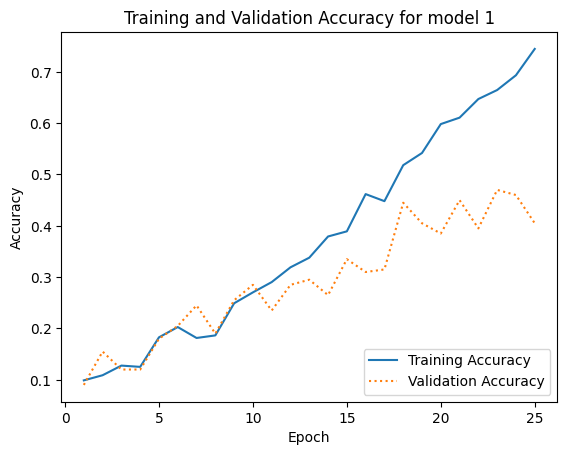

In [130]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for model 1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [103]:
from keras.layers import LeakyReLU

# Define model
reg_param = 0.001


model2 = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), input_shape=input_shape),
    LeakyReLU(alpha=0.1),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(216),
    LeakyReLU(alpha=0.1),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128),
    LeakyReLU(alpha=0.1),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10, activation='softmax')
])

# Compile model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 98, 68, 64)        1792      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 98, 68, 64)        0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 49, 34, 64)       0         
 g2D)                                                            
                                                                 
 flatten_31 (Flatten)        (None, 106624)            0         
                                                                 
 dense_76 (Dense)            (None, 216)               23031000  
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 216)               0         
                                                     

In [104]:
history2 = model2.fit(X_train_reshaped, y_train_one_hot, epochs=20, validation_data=(X_test_reshaped, y_test_one_hot))

Epoch 1/20


2023-04-16 19:38:25.937693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 5.2792 - accuracy: 0.1239

2023-04-16 19:38:28.773806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 3s 113ms/step - loss: 5.2792 - accuracy: 0.1239 - val_loss: 2.1029 - val_accuracy: 0.2500
Epoch 2/20
25/25 [==============================] - 2s 96ms/step - loss: 2.1115 - accuracy: 0.2403 - val_loss: 2.0683 - val_accuracy: 0.1900
Epoch 3/20
25/25 [==============================] - 2s 89ms/step - loss: 1.9993 - accuracy: 0.2628 - val_loss: 1.9821 - val_accuracy: 0.2550
Epoch 4/20
25/25 [==============================] - 2s 89ms/step - loss: 1.8890 - accuracy: 0.3041 - val_loss: 1.9971 - val_accuracy: 0.2250
Epoch 5/20
25/25 [==============================] - 2s 87ms/step - loss: 1.7691 - accuracy: 0.3479 - val_loss: 1.8451 - val_accuracy: 0.2850
Epoch 6/20
25/25 [==============================] - 2s 87ms/step - loss: 1.6079 - accuracy: 0.4543 - val_loss: 1.7730 - val_accuracy: 0.3350
Epoch 7/20
25/25 [==============================] - 2s 88ms/step - loss: 1.3617 - accuracy: 0.5244 - val_loss: 1.6710 - val_accuracy: 0.3700
Epoch 8/20
25/25 [=====

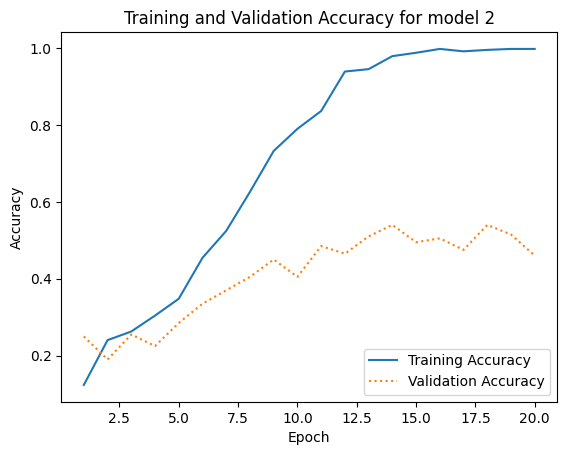

In [113]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [112]:
import tensorflow as tf

# Define the AlexNet model
def AlexNet(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        # Convolutional layer 1
        tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        tf.keras.layers.BatchNormalization(),

        # Convolutional layer 2
        tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        tf.keras.layers.BatchNormalization(),

        # Convolutional layer 3
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),

        # Convolutional layer 4
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),

        # Convolutional layer 5
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        tf.keras.layers.BatchNormalization(),

        # Flatten the output from the convolutional layers
        tf.keras.layers.Flatten(),

        # Fully connected layer 1
        tf.keras.layers.Dense(units=4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Fully connected layer 2
        tf.keras.layers.Dense(units=4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output layer
        tf.keras.layers.Dense(units=num_classes, activation='softmax')
    ])

    return model
model3 = AlexNet(input_shape, 10)
# Compile model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model3.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 23, 15, 96)        34944     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 11, 7, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_21 (Bat  (None, 11, 7, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_54 (Conv2D)          (None, 11, 7, 256)        614656    
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 5, 3, 256)        0         
 g2D)                                                            
                                                     

In [109]:
history3 = model3.fit(X_train_reshaped, y_train_one_hot, epochs=20, validation_data=(X_test_reshaped, y_test_one_hot))

Epoch 1/20


2023-04-16 19:39:37.282980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 3.0315 - accuracy: 0.1802

2023-04-16 19:39:43.096270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 7s 146ms/step - loss: 3.0315 - accuracy: 0.1802 - val_loss: 5.9092 - val_accuracy: 0.0650
Epoch 2/20
25/25 [==============================] - 2s 68ms/step - loss: 2.1320 - accuracy: 0.2365 - val_loss: 4.2810 - val_accuracy: 0.0650
Epoch 3/20
25/25 [==============================] - 2s 68ms/step - loss: 1.9450 - accuracy: 0.2879 - val_loss: 4.4332 - val_accuracy: 0.0750
Epoch 4/20
25/25 [==============================] - 2s 64ms/step - loss: 1.8114 - accuracy: 0.3229 - val_loss: 4.7994 - val_accuracy: 0.0900
Epoch 5/20
25/25 [==============================] - 2s 62ms/step - loss: 1.7209 - accuracy: 0.3680 - val_loss: 10.2604 - val_accuracy: 0.0750
Epoch 6/20
25/25 [==============================] - 2s 67ms/step - loss: 1.6505 - accuracy: 0.3917 - val_loss: 6.0424 - val_accuracy: 0.1800
Epoch 7/20
25/25 [==============================] - 2s 64ms/step - loss: 1.5404 - accuracy: 0.4293 - val_loss: 5.5076 - val_accuracy: 0.1550
Epoch 8/20
25/25 [====

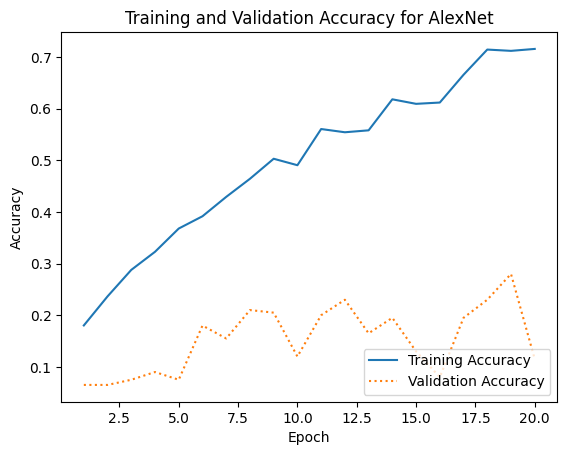

In [111]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for AlexNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

From the training, we can see that the accuracy for different models: 
- Logistic regression: 0.47
- SVC: 0.41
- MLP: doesn't run 
- CNN model1: 0.47
- CNN model2: 0.505
- ALexNet: 0.28


We can conclude that CNN has the best performance for classifying through image data. 

# Conclusion 

Comparing the accruacy between classifcation through feature data and classification through image data, we can see that feature data has better performance result. It might becuase feature data might be able to capture more meaningful and relevant information about the data compared to the raw image data. It might also be less noisy, or having lower dimensional compared to raw image data, which can make it easier for the model to learn a decision boundary between classes. From the modeling result, we can see that image data can have very high dimensionality, which can lead to overfitting or difficulty in training.


Reference: 
- [Work w/ Audio Data: Visualise, Classify, Recommend](https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend/notebook#Recommender-Systems)
- [Audio classification using convolutional neural networks](https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb)
- [github: multilayer_perceptron](https://github.com/scikit-learn/scikit-learn/blob/364c77e04/sklearn/neural_network/_multilayer_perceptron.py#L761)